In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# ============================================================================
# 1. LOAD DATA
# ============================================================================
print("Loading Data...")
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Save IDs
test_ids = df_test['founder_id'].copy()

# Drop IDs
df_train = df_train.drop('founder_id', axis=1)
df_test = df_test.drop('founder_id', axis=1)

# Target Encoding (Left=1, Stayed=0)
df_train['retention_status'] = df_train['retention_status'].map({'Left': 1, 'Stayed': 0})
y = df_train['retention_status']
X = df_train.drop('retention_status', axis=1)

# ============================================================================
# 2. ADVANCED PREPROCESSING
# ============================================================================
def process_data(df):
    df = df.copy()
    
    # --- 1. Text Cleaning ---
    str_cols = df.select_dtypes(include=['object']).columns
    for col in str_cols:
        df[col] = df[col].str.replace('’', "'").str.replace('‘', "'")

    # --- 2. Strict Ordinal Mappings (Preserve Rank) ---
    # Ratings
    scale_map_4 = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3} # For perf, reputation
    scale_map_5 = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3} # For WLB (same keys)
    sat_map = {'Low': 0, 'Medium': 1, 'High': 2, 'Very High': 3}
    
    # Sizes & Stages
    stage_map = {'Entry': 0, 'Mid': 1, 'Senior': 2}
    size_map = {'Small': 0, 'Medium': 1, 'Large': 2}
    vis_map = {'Low': 0, 'Medium': 1, 'High': 2, 'Very High': 3}
    
    # Education (Crucial to keep order)
    edu_map = {
        'High School': 0, 'Associate Degree': 1, "Bachelor's Degree": 2, 
        "Master's Degree": 3, 'PhD': 4
    }

    # Apply Mappings & Fill Ordinal NaNs with Median or specific value (e.g. -1)
    # Using -1 lets trees split "Missing" from "Low"
    df['startup_performance_rating'] = df['startup_performance_rating'].map(scale_map_4).fillna(-1)
    df['work_life_balance_rating'] = df['work_life_balance_rating'].map(scale_map_4).fillna(-1)
    df['venture_satisfaction'] = df['venture_satisfaction'].map(sat_map).fillna(-1)
    df['startup_reputation'] = df['startup_reputation'].map(scale_map_4).fillna(-1)
    
    df['startup_stage'] = df['startup_stage'].map(stage_map).fillna(-1)
    df['team_size_ordinal'] = df['team_size_category'].map(size_map).fillna(-1) # New Col
    df['founder_visibility'] = df['founder_visibility'].map(vis_map).fillna(-1)
    
    df['education_level'] = df['education_background'].map(edu_map).fillna(-1)
    
    # Drop original categorical columns that we just mapped
    df = df.drop(['team_size_category', 'education_background'], axis=1)

    # --- 3. Binary Features ---
    binary_cols = ['working_overtime', 'remote_operations', 'leadership_scope', 'innovation_support']
    for col in binary_cols:
        df[col] = df[col].map({'Yes': 1, 'No': 0}).fillna(0)

    # --- 4. Log Transform for Skewed Data ---
    # Revenue often has a "power law" distribution. Log1p brings it to normal scale.
    # We handle NaNs later, so ignore warning or fill temp 0
    df['log_revenue'] = np.log1p(df['monthly_revenue_generated'].fillna(0))

    # --- 5. Feature Engineering ---
    # Flag missing revenue before we fill it
    df['revenue_missing'] = df['monthly_revenue_generated'].isna().astype(int)
    
    # Fill Revenue with Median (Better than -999 for log features)
    rev_median = df['monthly_revenue_generated'].median()
    df['monthly_revenue_generated'] = df['monthly_revenue_generated'].fillna(rev_median)

    # Ratios
    df['age_when_joined'] = df['founder_age'] - df['years_with_startup']
    df['tenure_ratio'] = df['years_with_startup'] / df['founder_age']
    
    # Revenue per Team Size (Proxy) - use ordinal size + 1 to avoid div/0
    df['revenue_per_size_unit'] = df['monthly_revenue_generated'] / (df['team_size_ordinal'].replace(-1, 1) + 2)
    
    # Stress Metric
    # High Overtime (1) + Low WLB (0) -> High Stress
    wlb_score = df['work_life_balance_rating'].replace(-1, 1.5) # replace missing with neutral
    df['stress_index'] = df['working_overtime'] * (3 - wlb_score)

    return df

print("Processing Features...")
X_proc = process_data(X)
df_test_proc = process_data(df_test)

# --- 6. One-Hot Encoding (OHE) for NOMINAL Categoricals ---
# We do this AFTER standard processing. Nominal cols: Gender, Role, Status
nominal_cols = ['founder_gender', 'founder_role', 'personal_status']

# Get dummies (Drop first to reduce collinearity, though trees handle it fine)
X_final = pd.get_dummies(X_proc, columns=nominal_cols, dummy_na=True)
df_test_final = pd.get_dummies(df_test_proc, columns=nominal_cols, dummy_na=True)

# Align columns (ensure test has same cols as train)
X_final, df_test_final = X_final.align(df_test_final, join='left', axis=1, fill_value=0)

print(f"Final Feature Count: {X_final.shape[1]}")

# ============================================================================
# 3. MODEL TRAINING (XGBoost)
# ============================================================================
X_train, X_val, y_train, y_val = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

print("Training XGBoost...")
model = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.02,       # Lower learning rate for better generalization
    max_depth=7,              # Slightly deeper trees
    subsample=0.7,            # Row sampling to prevent overfitting
    colsample_bytree=0.6,     # Feature sampling
    gamma=0.1,                # Min split loss (regularization)
    reg_lambda=2,             # L2 Regularization
    reg_alpha=1,              # L1 Regularization
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',    # Logloss is stable for binary classification
    early_stopping_rounds=100
)

model.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)], 
    verbose=200
)

# ============================================================================
# 4. THRESHOLD OPTIMIZATION
# ============================================================================
print("\nOptimizing Threshold for Macro F1...")
val_probs = model.predict_proba(X_val)[:, 1]
best_macro_f1 = 0
best_thresh = 0.5

# Fine-grained search
for t in np.arange(0.30, 0.70, 0.001):
    preds = (val_probs >= t).astype(int)
    macro_f1 = f1_score(y_val, preds, average='macro')
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_thresh = t

print(f"Best Threshold: {best_thresh:.4f}")
print(f"Best Macro F1: {best_macro_f1:.4f}")

# ============================================================================
# 5. SUBMISSION
# ============================================================================
test_probs = model.predict_proba(df_test_final)[:, 1]
test_preds = (test_probs >= best_thresh).astype(int)

submission = pd.DataFrame({
    'founder_id': test_ids,
    'retention_status': ['Left' if p == 1 else 'Stayed' for p in test_preds]
})

submission.to_csv('submission_xgb_improved.csv', index=False)
print("Submission saved to submission_xgb_improved.csv")

Loading Data...
Processing Features...
Final Feature Count: 38
Training XGBoost...
[0]	validation_0-logloss:0.68722
[200]	validation_0-logloss:0.49236
[400]	validation_0-logloss:0.48268
[586]	validation_0-logloss:0.48272

Optimizing Threshold for Macro F1...
Best Threshold: 0.4660
Best Macro F1: 0.7506
Submission saved to submission_xgb_improved.csv


C:\Users\hrush\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Data...
Processing Features...


[I 2025-11-18 17:47:48,609] A new study created in memory with name: no-name-fc4442f8-a373-4938-a9e8-69e86046e5bc



Starting Optuna Optimization (200 Trials)...


[I 2025-11-18 17:47:50,318] Trial 0 finished with value: 0.7504692789298228 and parameters: {'n_estimators': 968, 'learning_rate': 0.04946263882615435, 'max_depth': 8, 'subsample': 0.5309307845509619, 'colsample_bytree': 0.9337149187520893, 'gamma': 3.474288959053435, 'reg_lambda': 1.1491378852717327, 'reg_alpha': 2.8176660149615165, 'min_child_weight': 1}. Best is trial 0 with value: 0.7504692789298228.
[I 2025-11-18 17:47:57,158] Trial 1 finished with value: 0.7521042886961713 and parameters: {'n_estimators': 1563, 'learning_rate': 0.01136678201336709, 'max_depth': 5, 'subsample': 0.8524219284928058, 'colsample_bytree': 0.6425707394721034, 'gamma': 4.78960147784384, 'reg_lambda': 0.7399309007500687, 'reg_alpha': 4.567502778793022, 'min_child_weight': 1}. Best is trial 1 with value: 0.7521042886961713.
[I 2025-11-18 17:47:58,494] Trial 2 finished with value: 0.7500583305607793 and parameters: {'n_estimators': 712, 'learning_rate': 0.07401397843985569, 'max_depth': 7, 'subsample': 0.87


Best Macro F1 found: 0.7552
Best Params: {'n_estimators': 892, 'learning_rate': 0.07983279403529749, 'max_depth': 3, 'subsample': 0.7815439391716676, 'colsample_bytree': 0.7614581006431617, 'gamma': 4.823000062208592, 'reg_lambda': 2.4881293554392454, 'reg_alpha': 2.3577736782409593, 'min_child_weight': 5}

Generating Plots...


C:\Users\hrush\AppData\Local\Temp\ipykernel_16840\202824865.py:163: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)
C:\Users\hrush\AppData\Local\Temp\ipykernel_16840\202824865.py:169: ExperimentalWarning: optuna.visualization.matplotlib._slice.plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)
C:\Users\hrush\AppData\Local\Temp\ipykernel_16840\202824865.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plots saved: xgb_optuna_history.png, xgb_optuna_importance.png, xgb_optuna_slice.png

Training Final Model with Best Params...
[0]	validation_0-logloss:0.67791
[200]	validation_0-logloss:0.48005
[400]	validation_0-logloss:0.47865
[594]	validation_0-logloss:0.47869
Fine-tuning threshold...
Final Optimal Threshold: 0.5040
Final Validation Macro F1: 0.7550
Submission saved to submission_xgb_optuna.csv


<Figure size 1000x600 with 0 Axes>

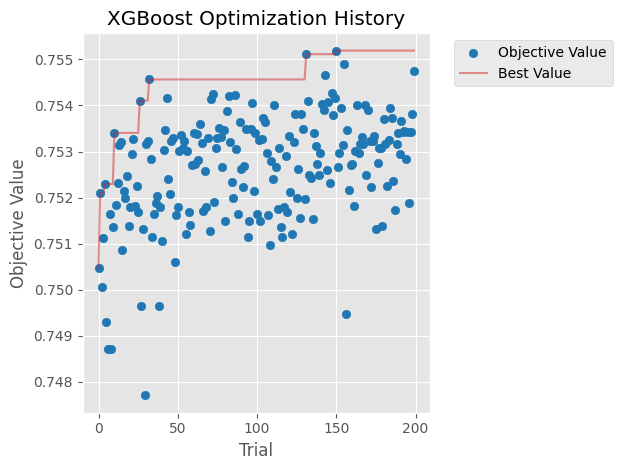

<Figure size 1000x600 with 0 Axes>

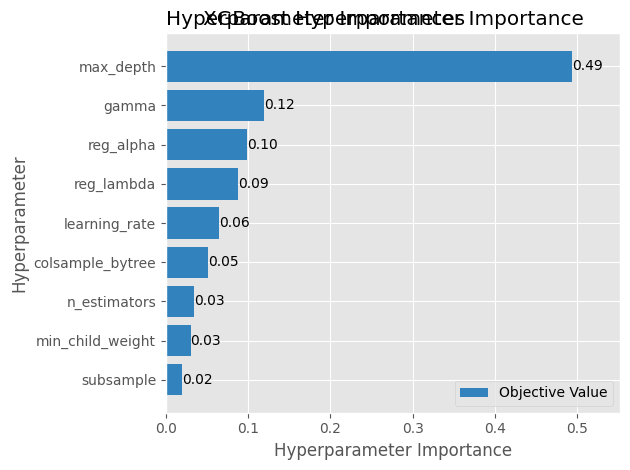

<Figure size 1200x800 with 0 Axes>

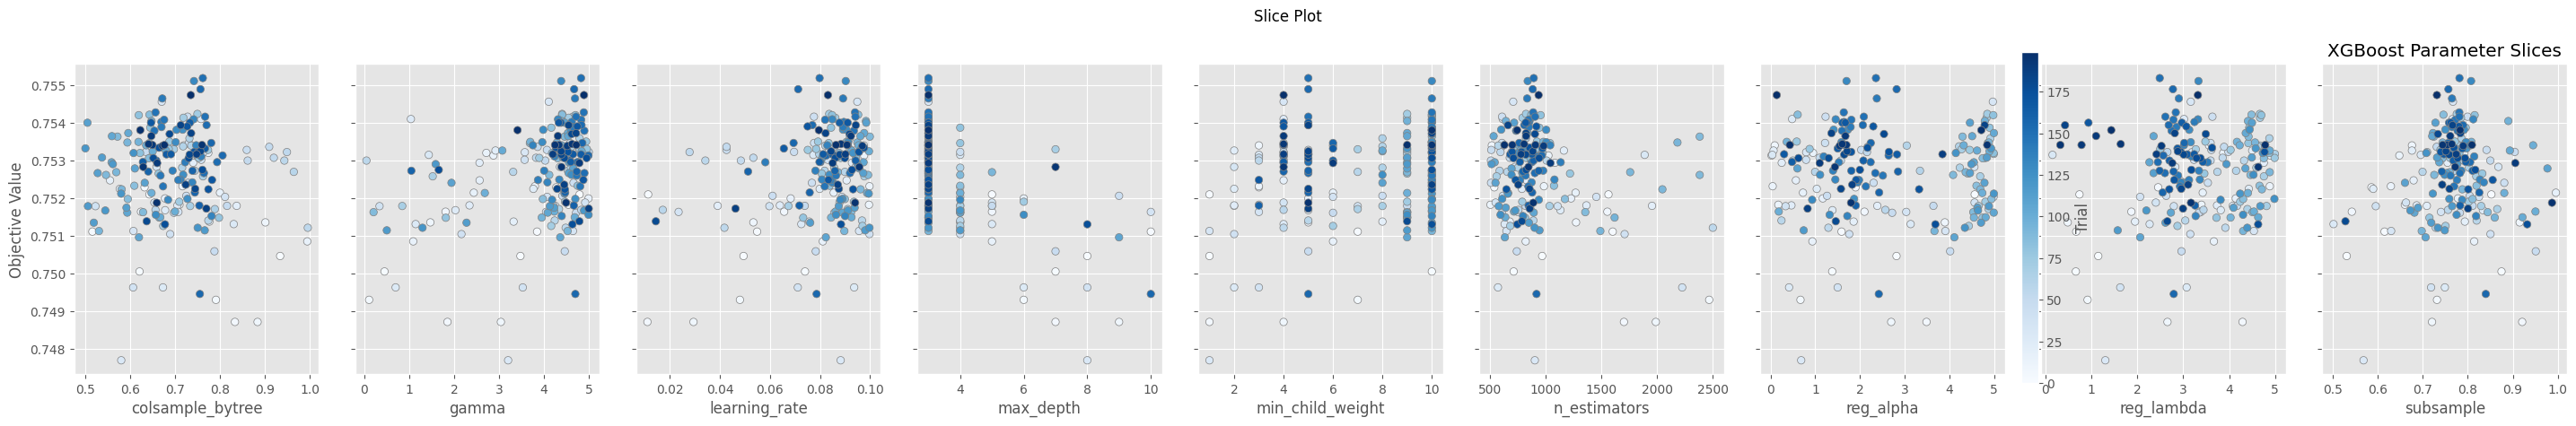

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances, plot_slice
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# ============================================================================
# 1. LOAD & PREPARE DATA
# ============================================================================
print("Loading Data...")
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Save IDs
test_ids = df_test['founder_id'].copy()

# Drop IDs
df_train = df_train.drop('founder_id', axis=1)
df_test = df_test.drop('founder_id', axis=1)

# Target Encoding (Left=1, Stayed=0)
df_train['retention_status'] = df_train['retention_status'].map({'Left': 1, 'Stayed': 0})
y = df_train['retention_status']
X = df_train.drop('retention_status', axis=1)

# ============================================================================
# 2. ADVANCED PREPROCESSING
# ============================================================================
def process_data(df):
    df = df.copy()
    
    # --- Text Cleaning ---
    str_cols = df.select_dtypes(include=['object']).columns
    for col in str_cols:
        df[col] = df[col].str.replace('’', "'").str.replace('‘', "'")

    # --- Ordinal Mappings ---
    scale_map = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
    sat_map = {'Low': 0, 'Medium': 1, 'High': 2, 'Very High': 3}
    stage_map = {'Entry': 0, 'Mid': 1, 'Senior': 2}
    size_map = {'Small': 0, 'Medium': 1, 'Large': 2}
    vis_map = {'Low': 0, 'Medium': 1, 'High': 2, 'Very High': 3}
    edu_map = {
        'High School': 0, 'Associate Degree': 1, "Bachelor's Degree": 2, 
        "Master's Degree": 3, 'PhD': 4
    }

    # Apply Mappings
    df['startup_performance_rating'] = df['startup_performance_rating'].map(scale_map).fillna(-1)
    df['work_life_balance_rating'] = df['work_life_balance_rating'].map(scale_map).fillna(-1)
    df['venture_satisfaction'] = df['venture_satisfaction'].map(sat_map).fillna(-1)
    df['startup_reputation'] = df['startup_reputation'].map(scale_map).fillna(-1)
    df['startup_stage'] = df['startup_stage'].map(stage_map).fillna(-1)
    df['team_size_ordinal'] = df['team_size_category'].map(size_map).fillna(-1)
    df['founder_visibility'] = df['founder_visibility'].map(vis_map).fillna(-1)
    df['education_level'] = df['education_background'].map(edu_map).fillna(-1)
    
    # Drop mapped categorical columns
    df = df.drop(['team_size_category', 'education_background'], axis=1)

    # --- Binary Features ---
    binary_cols = ['working_overtime', 'remote_operations', 'leadership_scope', 'innovation_support']
    for col in binary_cols:
        df[col] = df[col].map({'Yes': 1, 'No': 0}).fillna(0)

    # --- Numeric Transformations ---
    # Log transform revenue
    df['log_revenue'] = np.log1p(df['monthly_revenue_generated'].fillna(0))
    
    # Fill Revenue with Median for the raw column
    rev_median = df['monthly_revenue_generated'].median()
    df['monthly_revenue_generated'] = df['monthly_revenue_generated'].fillna(rev_median)

    # --- Feature Engineering ---
    df['age_when_joined'] = df['founder_age'] - df['years_with_startup']
    df['tenure_ratio'] = df['years_with_startup'] / df['founder_age']
    # Avoid div/0
    df['revenue_per_size_unit'] = df['monthly_revenue_generated'] / (df['team_size_ordinal'].replace(-1, 1) + 2)
    
    # Stress Index
    wlb_score = df['work_life_balance_rating'].replace(-1, 1.5)
    df['stress_index'] = df['working_overtime'] * (3 - wlb_score)

    return df

print("Processing Features...")
X_proc = process_data(X)
df_test_proc = process_data(df_test)

# --- One-Hot Encoding for Nominal Cols ---
nominal_cols = ['founder_gender', 'founder_role', 'personal_status']
X_final = pd.get_dummies(X_proc, columns=nominal_cols, dummy_na=True)
df_test_final = pd.get_dummies(df_test_proc, columns=nominal_cols, dummy_na=True)

# Align Columns
X_final, df_test_final = X_final.align(df_test_final, join='left', axis=1, fill_value=0)

# Split Data
X_train, X_val, y_train, y_val = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================================================
# 3. OPTUNA HYPERPARAMETER TUNING
# ============================================================================
print("\nStarting Optuna Optimization (200 Trials)...")

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        # Fixed
        'random_state': 42,
        'n_jobs': -1,
        'eval_metric': 'logloss',
        'early_stopping_rounds': 50
    }

    model = XGBClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    # Optimize Threshold for this specific trial
    preds_proba = model.predict_proba(X_val)[:, 1]
    best_trial_f1 = 0
    
    # Quick scan (0.3 to 0.7) to find best Macro F1 for this model
    for t in np.arange(0.3, 0.7, 0.05):
        p = (preds_proba >= t).astype(int)
        f1 = f1_score(y_val, p, average='macro')
        if f1 > best_trial_f1:
            best_trial_f1 = f1
            
    return best_trial_f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print(f"\nBest Macro F1 found: {study.best_value:.4f}")
print("Best Params:", study.best_params)

# ============================================================================
# 4. PLOTTING
# ============================================================================
print("\nGenerating Plots...")

plt.figure(figsize=(10, 6))
plot_optimization_history(study)
plt.title('XGBoost Optimization History')
plt.tight_layout()
plt.savefig('xgb_optuna_history.png')

plt.figure(figsize=(10, 6))
plot_param_importances(study)
plt.title('XGBoost Hyperparameter Importance')
plt.tight_layout()
plt.savefig('xgb_optuna_importance.png')

plt.figure(figsize=(12, 8))
plot_slice(study)
plt.title('XGBoost Parameter Slices')
plt.tight_layout()
plt.savefig('xgb_optuna_slice.png')

print("Plots saved: xgb_optuna_history.png, xgb_optuna_importance.png, xgb_optuna_slice.png")

# ============================================================================
# 5. FINAL MODEL & SUBMISSION
# ============================================================================
print("\nTraining Final Model with Best Params...")

best_params = study.best_params
# Ensure fixed params are present
best_params.update({
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'logloss',
    'early_stopping_rounds': 100
})

final_model = XGBClassifier(**best_params)
final_model.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)], 
    verbose=200
)

# Final Threshold Optimization
val_probs = final_model.predict_proba(X_val)[:, 1]
best_macro_f1 = 0
best_thresh = 0.5

print("Fine-tuning threshold...")
for t in np.arange(0.30, 0.70, 0.001):
    preds = (val_probs >= t).astype(int)
    macro_f1 = f1_score(y_val, preds, average='macro')
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_thresh = t

print(f"Final Optimal Threshold: {best_thresh:.4f}")
print(f"Final Validation Macro F1: {best_macro_f1:.4f}")

# Submission
test_probs = final_model.predict_proba(df_test_final)[:, 1]
test_preds = (test_probs >= best_thresh).astype(int)

submission = pd.DataFrame({
    'founder_id': test_ids,
    'retention_status': ['Left' if p == 1 else 'Stayed' for p in test_preds]
})

filename = 'submission_xgb_optuna.csv'
submission.to_csv(filename, index=False)
print(f"Submission saved to {filename}")